# 1. Binary Classification

## Logistic Loss Objective Value

Objective Function:
$ q (w; x, y) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big)$ 

l2 regularizer addition:
$\frac{\lambda}{2} \| w \|_2^2 $.

l1 regularizer addition: 
$\lambda| w \|^1 $

In [5]:
import numpy

# y: scalar 
# x: 1 by d vector 
# w: d by 1 vector
# lam: scalar 
# l1 and l2: boolean
def logistic_loss(y,x,w,l1=False,l2=False,lam=0):
    exponent = float(numpy.exp(-y * numpy.dot(x,w))) # scalar
    objective = numpy.log(1 + exponent) 
    if l2:
        objective += lam/2 * numpy.sum(numpy.multiply(w,w))
    if l1:
        objective += numpy.sum(numpy.abs(w)) 
    return objective

In [13]:
# gradient of logisitic loss
# y: scalar 
# x: 1 by d vector 
# w: d by 1 vector
# lam: scalar 
# l1 and l2: boolean
def logistic_gradient(y,x,w,l1=False,l2=False, lam=0):
    d, _ = w.shape
    exponent = float(numpy.exp(y * numpy.dot(x,w))) # scalar
    derivative = (-y * x) / (1 + exponent) 
    derivative = derivative.reshape((d,1))# d by 1
    if l2:
        derivative += lam * w
    if l1:
        derivative += numpy.multiply(numpy.sign(w),w)
    return derivative

# 2. Regression

## Linear Regression

TODO: write equations

In [7]:
# y: scalar 
# x: 1 by d vector 
# w: d by 1 vector
# lam: scalar 
# l1 and l2: boolean
def linear_loss(y,x,w,l2=False,l1=False,lam=0):
    loss = numpy.dot(x,w) - y
    loss = numpy.multiply(loss,loss)
    if l2:
        loss += lam * numpy.multiply(w,w)
    if l1:
        loss += lam * numpy.sum(numpy.abs(w))
    return loss

In [8]:
# y: scalar 
# x: 1 by d vector 
# w: d by 1 vector
# lam: scalar 
# l1 and l2: boolean
def linear_gradient(y,x,w,l2=False,l1=False,lam=0):
    d, _ = w.shape
    scalar = numpy.dot(w,x) - y
    vector = scalar * x 
    vector.reshape((d,1))
    if l2:
        vector += lam * w
    if l1:
        vector += numpy.multiply(numpy.sign(w),w)
    return vector

## 3. SAGA Algorithm

In [20]:
# X: training set, n by d 
# y: training labels, n by 1 
# step_size, can't go wrong with 1/3L
# lam: scalar
# max_epochs = scalar
# proximal: not always used default should be lambda x
# obj_func: R^d -> R^1
# grad_func: R^d -> R^d
# l1 and l2 = Booleans
def saga(X,y,step_size,max_epochs,proximal,obj_func,grad_func,l1=False,l2=False,lam=0):
    # average obj values per epoch
    obj_vals = []
    n, d = X.shape  
    w = numpy.zeros((d,1)) # d by 1 weight vector
    # initialize table with derivative w/weight 0
    derivatives = numpy.zeros((n,d))
    for i in range(d):
        derivatives[i,:] = grad_func(y[i],X[i,:],w,l1,l2,lam).reshape(9)
        
    for epoch in range(max_epochs):
        # shuffle data points for an epoch
        permutation = numpy.random.permutation(n)
        X_shuffled = X[permutation,:]
        y_shuffled = y[permutation,:]
        obj_epoch = 0
        for i in range(n):
            # target data point and label
            xi = X_shuffled[i,:]
            yi = y_shuffled[i]

            updated_deriv = grad_func(yi,xi,w,l1=l1,l2=l2,lam=lam) # d by 1
            previous_deriv = derivatives[permutation[i],:].reshape((d,1)) # d by 1
            derivatives[permutation[i],:] = updated_deriv.reshape(d)
            table_avg = numpy.mean(derivatives,axis=0).reshape((d,1))
            update = updated_deriv - previous_deriv + table_avg
            w = w - (step_size * update)
            # apply proximal operator
            w = proximal(w)
            obj_iter = obj_func(y_shuffled[i],X_shuffled[i,:],w,l1=l1,l2=l2,lam=lam)
            obj_epoch += obj_iter

        obj_epoch /= n
        obj_vals.append(obj_epoch)
        print("Obj val at epoch " + str(epoch) + ' is ' + str(obj_epoch))
    return w,obj_vals

# 4. Import Datasets

## 4.1 Mnist 

Data from http://yann.lecun.com/exdb/mnist/

### 4.1.1 Read files

In [3]:
#https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40
import struct

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return numpy.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

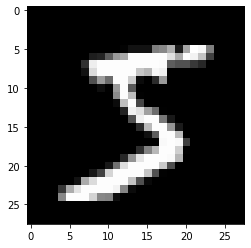

The testing label is 5


In [16]:
import matplotlib.pyplot as plt 

X_test = read_idx("t10k-images-idx3-ubyte")
y_test = read_idx("t10k-labels-idx1-ubyte")

X_train = read_idx("train-images-idx3-ubyte")
y_train = read_idx("train-labels-idx1-ubyte")


plt.imshow(X_train[0,:,:],cmap='gray')
plt.show()
print('The testing label is ' + str(y_train[0]))

### 4.1.2 Process Labels 

As explained in http://proceedings.mlr.press/v32/defazio14.pdf the digits 0-4 are class 1 and 5-9 class 2

In [17]:
y_train = list(map(lambda x:0 if x < 5 else 1,y_train))

y_test = list(map(lambda x:0 if x <5 else 1, y_test))

### 4.1.3 Vectorize images and add a 1 column to simulate the intercept

In [ ]:

X_train = numpy.concatenate((X_train, numpy.ones((n_train, 1))), axis=1)

In [19]:
proximal = lambda x: x
_,eigs,_ = numpy.linalg.svd(X_train * X_train.T)
n,d = numpy.shape(X_train)
alpha = 1E-6
step_size = 1 / (n * alpha + 1/4 * eigs[0]) 
saga(X_train,y_train,step_size,100,proximal,logistic_loss,logistic_gradient,l2=True,lam=alpha)

ValueError: operands could not be broadcast together with shapes (60000,28,28) (28,28,60000) 